# Route time optimization and solutions quality: A CBC and SCIP comparison.

Recently there have been concerns about how the actual (12.02.2021) eClever routing algorithm, for some specific cases, fails to properly choose charging regimes so that the overall charging time is reasonably short. For example, sometimes the algorithm decides to charge the battery State Of Charge (SOC) up to 100%. At these high SOC regimes the charge process takes long time since the loading power is drastically decreased, hence resulting in a larger overall route time.

In this report we have calculated several routes for two different optimization strategies. After carefully analyzing the results it was found that by optimizing the charge time only, the overall total route time of the calculated routes is reduced. Additionally we have repeated these calculations using another solver and have found that there is potential for increasing the performance of the current algorithm in terms of calculation time, as well at on the *"quality"* of the resulting routes in terms of their obtained gap values.  

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Strategy" data-toc-modified-id="Strategy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Strategy</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Gap:" data-toc-modified-id="Gap:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Gap:</a></span></li><li><span><a href="#Normalized-charge-time-and-total-time:" data-toc-modified-id="Normalized-charge-time-and-total-time:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Normalized charge time and total time:</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

## Strategy

During the evaluation of this problem (see bug NEX-5121, NEX-5191), two main aspects where discussed, namely: 

1. **Modification of the objective function of the linear optimization in the routing algorithm:** So far we have been optimizing the drive time together with the charging time so that the overall route time is minimum. The proposal here was to optimize only the charge time and see if this enhances the decision making of the algorithm regarding the charging regimes of the charge curves and, hence, possibly enhancing the overall route time.


2. **Limitations of capabilities and performance of the used solver:** In our algorithm we model our routing problem as a Mixed Integer Linear Programming (MILP) problem. Depending on the MILP problem, the time required to find an optimal solution could be really long. Due to practical considerations we cannot wait until the solver finds an optimal solution to the problem. Therefore we put some limitations on when to stop the optimization procedure and ask the solver which was the best solution found so far. The criteria that we use in our algorithm is that the *gap* parameter, which we will discuss in detail later, must have a minimum value of 0.2, if this is not achieved, the optimization is stopped after 30 seconds of CPU time. Keep in mind that an optimal solution means that the gap is equal to 0. 

 Now, how fast will the solver find an optimal solution depends on the performance of the solver. Lets take for example a comparison of two hypothetical solvers one faster than the other. For a given MILP problem, the slower solver will find a solution after 30 seconds of CPU time with a gap of 0.3. The faster solver could find a solution with a gap of 0.18 before the 30 seconds are over. In this regard, the solution of the faster solver is better than that of the slower since the gap value is closer to 0 which is optimality. For our purposes, this entails shorter route times. Now consider that if the performance of the faster solver is good enough, one could also decrease the gap limitation so that the delivered solved routes have solutions potentially closer to optimality. 

In order to study the effect of these two aspects on the route times and quality we have performed an experiment where we have calculated several routes (see table below) for 7 different electro vehicles (EV) namely, Model S 75D, Model 3, Ioniq Elektro, Leaf 40kWh, e-Golf, Model S 60 and ID.3. These EVs  have very different battery capacities and charging options, hence ensuring that the variety of route problems is wide. 

In [193]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from scipy import stats

data = pd.read_csv('scip_cbc_comp_10022021.csv')
# normalize charge and total times
data['norm_charge_time'] = data.charge_time/data.total_time
data['norm_tot_time'] = data.total_time/data.total_distance

cities = ['Berlin','Dresden','Hamburg','München','Köln']

print('Route matrix used for the algorithm test.')
pd.DataFrame([['{}-{}'.format(origin, destination) if origin!=destination else '' for destination in cities ] 
              for origin in cities ], columns=cities, index= cities)

Route matrix used for the algorithm test.


Berlin          Dresden          Hamburg          München  \
Berlin                    Berlin-Dresden   Berlin-Hamburg   Berlin-München   
Dresden  Dresden-Berlin                   Dresden-Hamburg  Dresden-München   
Hamburg  Hamburg-Berlin  Hamburg-Dresden                   Hamburg-München   
München  München-Berlin  München-Dresden  München-Hamburg                    
Köln        Köln-Berlin     Köln-Dresden     Köln-Hamburg     Köln-München   

                 Köln  
Berlin    Berlin-Köln  
Dresden  Dresden-Köln  
Hamburg  Hamburg-Köln  
München  München-Köln  
Köln

In order to tackle aspect 1 (Objective function) we have run our algorithm for each EV and route using two different optimization methods. In the first method we have optimized simultaneously the drive and charge time, whereas in the second run we have optimized only the charging time. That corresponds to a total of 140 calculated routes for each optimization method. 

To evaluate aspect 2 (Solver performance), we have repeated the same procedure as before but this time using the [SCIP](https://scipopt.org/index.php) solver. This is still a non-commercial solver, however, only for academic purposes. For commercial use one needs to acquire a license. The idea here is to compare the solver that we are currently using to other ones. There are other solvers in the market like [Gurubi](https://www.gurobi.com/)  and [CPLEX](https://www.ibm.com/analytics/cplex-optimizer) which are much faster and allow full control on the optimization procedure. However, with our current problem requirements, optimization of our routes is not possible with the free versions of these solvers.  

## Results

Let us start by having a look at the actual data. The figure below shows a bar plot of the Total Time in minutes for all the routes calculated driving a ID.3 with the current solver [CBC](https://www.coin-or.org/) and after optimizing both drive and charge time together. In the figure we can also see how much of the time corresponds to charging (blue) and how much to driving (orange).

Fig. 1


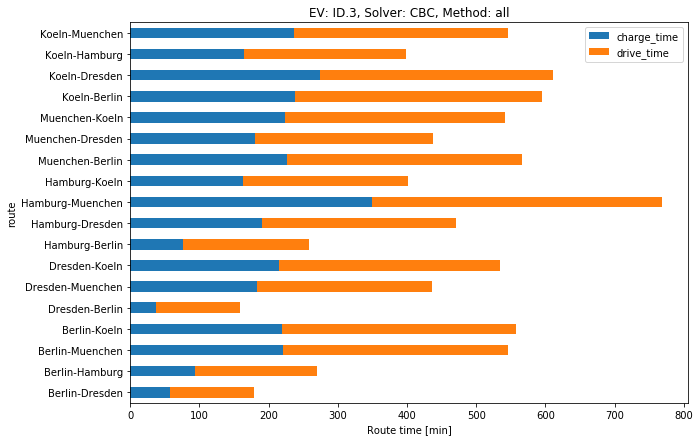

In [335]:
filter_ = (data.auto == "ID.3") & (data.solver == "CBC") & (data.method == "all")
ax = data[filter_][["charge_time", "drive_time", "route"]].set_index("route").plot(
    kind='barh', stacked=True, figsize=(10,7), title="EV: ID.3, Solver: CBC, Method: all")
ax.set_xlabel("Route time [min]");
print("Fig. 1")

The figure below shows a similar plot but this time we compare the total route time for the same route obtained when optimizing only the charge time (blue) and after optimizing both the charge and drive times (orange). This method we will call *all* from optimizing all times. As observed, for some cases, the overall drive time is shorter when optimizing only the charge time, but for other cases, it is actually by optimizing both drive and charge times what decreases the overall route time. 

Fig. 2


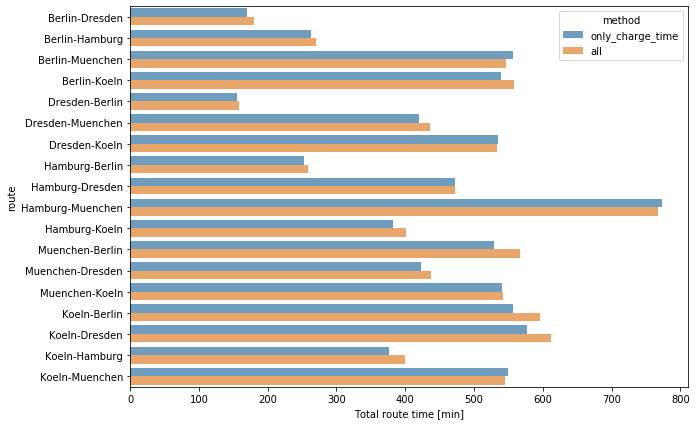

In [337]:
plt.figure(figsize=(10,7))
filter_ = (data.auto == "ID.3") & (data.solver == "CBC") & (~data.route.isin(["Dresden-Hamburg", "Muenchen-Hamburg"]))
sn.barplot(data=data[filter_], x='total_time', y="route", hue="method", alpha=0.7)
plt.xlabel("Total route time [min]");
print("Fig. 2")

Now, the idea of this study is to identify which of these optimization methods (i.e, only charge time vs. all times) in average reduces the overall route time for the calculated routes. But before we go into details let us clarify the metrics that will be used to compare and analyze the collected data. 

### Gap:

The quantity we will use to measure the solution *"quality"* of a calculated route is the **gap**. MILP problems are normally solved using the [*Branch and bound/Branch and cut*](https://www.gurobi.com/resource/mip-basics/) algorithms. Generally the gap is the magnitude of the difference between the objective function values of the best known solution (best bound $Obj_{BB}$) and the best bound remaining ($Obj$) divided by the best bound.

$$gap=\frac{|Obj_{BB}-Obj|}{Obj_{BB}}$$

When the gap is zero, the solution is optimal.  

For example, currently in our algorithm we instruct the solver to stop as soon as it has found a feasible integer solution proved to be within 20 percent of optimal.

### Normalized charge time and total time:

We aim to compare the charge and overall route times of the calculated routes, however, since these are calculated for routes with different lengths, it is necessary to normalize the results so they can be compared. The way we will normalize the charging time is by dividing it by the total route time. In this way we can interpret the charging time as a fraction of the total time. For example, a normalized charge time of 0.3 means that the charging time is about 30% of the total route time.  

The total drive time, on the other hand, will be normalized by dividing it by the route length in km. This will yield a quantity with units of min/km that tells us the expected time length by driven km. For example, taking a normalized total time 0.8 min/km and assuming a route of 500 km, the expected time length of that route is 
$500~km \times 0.8~min/km = 400~min$ which is about 6 h 40 min. We can then combine these quantities and estimate how much of these 400 minutes correspond to charging time by multiplying by the normalize charging time, e.g., $400~min\times 0.3 = 120~min$.

Therefore the optimization method that tends to reduce the overall time, would be the best. 

The figure below shows density histograms of the normalized charge time (left) and the normalized total route time (right) for routes calculated using the current CBC solver (upper row) and those calculated using SCIP (lower row). The solid lines are a fit to the data assuming a normal distribution. The peak (highest point) of the solid curves correspond to the statistical mean value of the data.  

Lets focus first on the upper row, i.e., routes calculated with CBC. As observed, in the upper left plot, the distribution plot when optimizing only the charge curve (blue) is shifted to the left as compared to the case where all times are optimized (orange). This is also reflected in the normalized total time, which means that in average, by optimizing only the charge time, the total time is also optimized (minimized).

Fig. 3


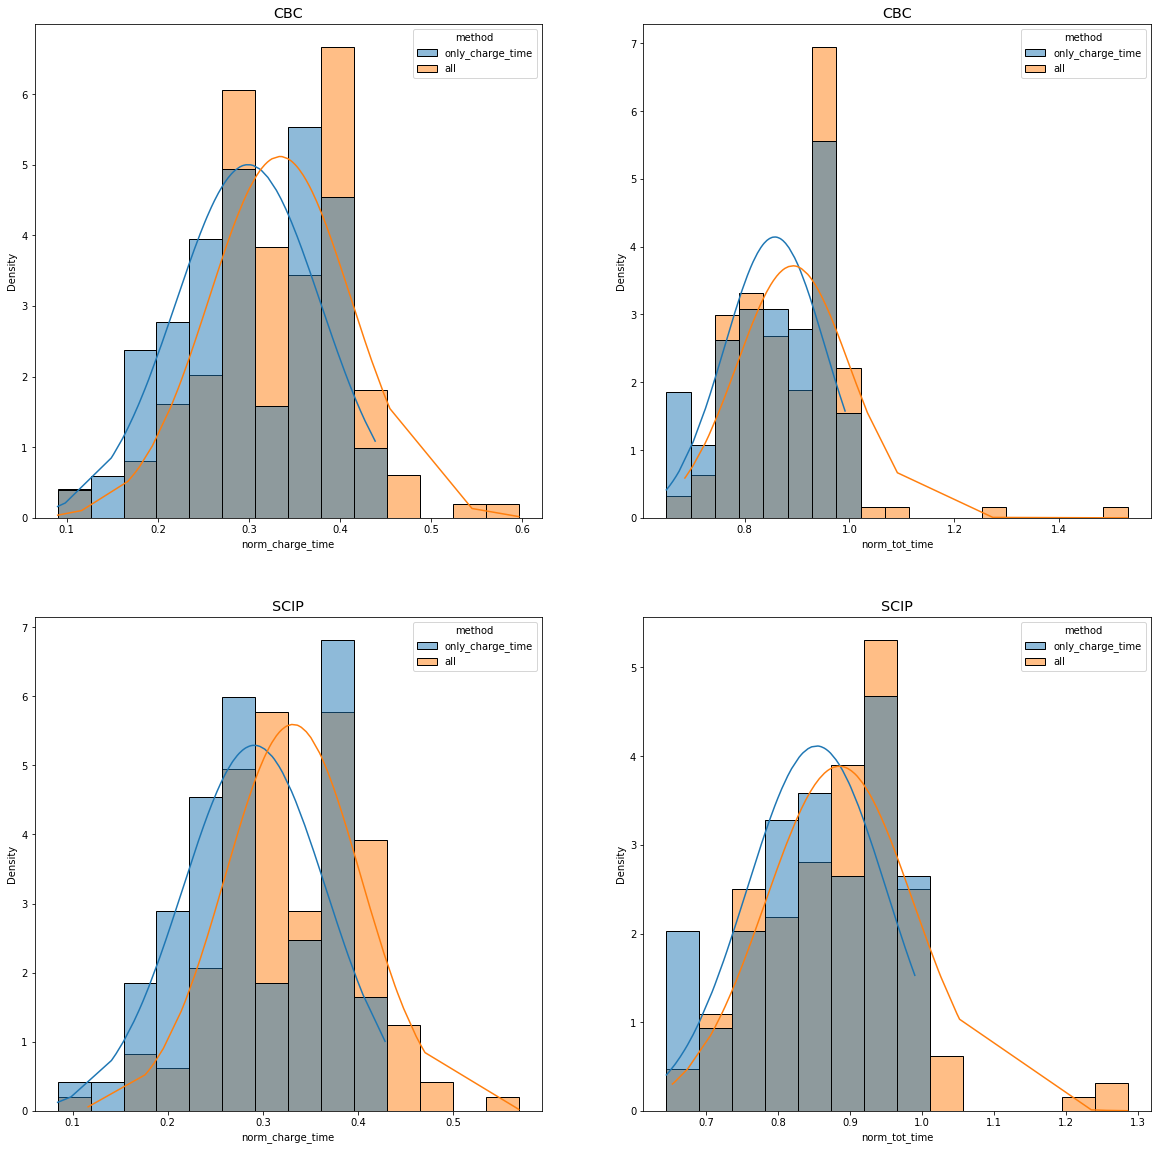

In [408]:
fig, axs = plt.subplots(2,2,figsize=(20,20))
for idx1, solver in enumerate(data.solver.unique()):
    for idx2, time in enumerate(["norm_charge_time", "norm_tot_time"]):
        ax1 = axs[idx1, idx2]
        ax1.set_title(solver, fontsize="x-large")
        sn.histplot(data=data[data.solver==solver], x=time, 
                    hue='method',stat="density", common_norm=False, ax=ax1)
        for method in data.method.unique():
            x = data[(data.solver==solver) & (data.method==method)][time].values
            x.sort()
            ax1.plot(x, norm.pdf(x, loc=x.mean(), scale=x.std()))       
print("Fig. 3")

In [325]:
print("Table 1: Summary of mean values")
cols = ['gap', 'wall time', 'solver', 'method', 
       'norm_charge_time', 'norm_tot_time']
data[cols].groupby(['solver', 'method']).mean().round(2)


Table 1: Summary of mean values


gap  wall time  norm_charge_time  norm_tot_time
solver method                                                            
CBC    all               0.36    5024.90              0.33           0.89
       only_charge_time  0.37    5273.23              0.30           0.86
SCIP   all               0.21   15115.32              0.33           0.89
       only_charge_time  0.32   19698.61              0.29           0.85

Table 1 above shows a summary of the mean values of the normalized charge and total times for all the routes calculated the two optimization methods using both CBC and SCIP solvers. Also, the mean values of the gap and the wall time (linear optimization time) are present.

Next we will perform a statistical t-Test to determine if the difference in mean values of the normalized total route time is statistically significant:

In [400]:
def ttest_paired_results(X1,X2):
    #perform t-Test for dependent paired values
    t_val, p = stats.ttest_rel(X1, X2)
    df_val = len(X1)-1
    # correlation coefficient to datermine the effect size 
    # (0.1 = weak, 0.3 = middle, 0.5 = strong after Cohen (1992))
    r = round(np.sqrt((t_val**2)/(t_val**2+df_val)),3)
    res = pd.DataFrame({'t-Test Paired':[round(t_val, 3),round(p,3), df_val, r]}, index=['T', 'p', 'df', 'r'])
    return res

cbc_only_charge = data[(data.solver=='CBC') & (data.method=='only_charge_time')]

# filter missing routes in all subset
id3_filter = cbc_only_charge[(cbc_only_charge.auto=="ID.3") 
                                  & (cbc_only_charge.route.isin(["Muenchen-Hamburg", "Dresden-Hamburg"]))
                                 ].index.values

leaf_filter = cbc_only_charge[(cbc_only_charge.auto=="Leaf 40kWh") 
                              & (cbc_only_charge.route=="Koeln-Dresden")].index.values

filter_index = np.append(leaf_filter, id3_filter)

cbc_only_charge = cbc_only_charge[~cbc_only_charge.index.isin(filter_index)]
cbc_only_charge = cbc_only_charge['norm_tot_time'].values

cbc_all = data[(data.solver=='CBC') & (data.method=='all')]['norm_tot_time'].values

ttest_res = ttest_paired_results(cbc_only_charge, cbc_all)
print("Table 2: ")
ttest_res

Table 2: 


t-Test Paired
T          -4.697
p           0.000
df        136.000
r           0.374

Table 2 above shows the results of the t-Test for paired dependent samples. After judging the result of the t-Test it is observed that optimizing only the charge time has a statistically significant influence on the overall route time (T = -4.697, p < .005, n = 137). After optimizing only the charge time (mean norm route time = 0.86) the route times are shorter than the case where both drive and charge times are optimized together (mean norm route time = 0.89). The effect size is in the middle-strong range after Cohen (1992) with a Pearson's correlation coefficient of r = 0.374.

We can then conclude, based on the data in Table 1, that by optimizing only the charge time we get in average a normalized route time of 0.86 min/km, for which the 30% corresponds to charging time, in contrast to the 0.89 min/km and 33% when optimizing both drive and charge times simultaneously.

To make it more visual, lets take an example of a route of 500 km length, we will then in average calculate for this route the following times, depending on the optimization method:

| Method           | Total route time [min] | Charge Time [min]  |
| -------------    |-------------           | -----              |
| only charge time | 430                    |   129              |
| all              | 445                    |   147              |

Also, regarding the gap value, we see from table 1 that the gap is basically the same, although, these can not be directly compared since the objective function is different for both methods. Regarding the wall time, which is the actual time the optimization took to calculate the route, we see that when only the charge is optimized, the calculation time is in average slightly increased by about 200 milliseconds. 

Changing now to the SCIP solver, the histograms at the lower row in Figure 4 show similar behavior as when CBC is used, i.e., optimizing only the charge time results in a overall shorter route time.

Let us now compare the results obtained with CBC and SCIP. From table 1, we see that the normalized total route time and the normalized charge time are in average slightly better for the routes calculated with SCIP, but perhaps the most important difference is the mean gap values. In average the gap parameter is much better for routes calculated with SCIP meaning that these are closer to optimal as compared to those calculated with CBC. For the case of routes calculated optimizing both drive and charge times, the gap is decreased by almost 42%. 14% when only the charge time is optimized. What this means is that the quality of the resulting routes using SCIP is better than those calculated using CBC.

Lets have a closer look at this by checking the gap histograms.

Fig. 4


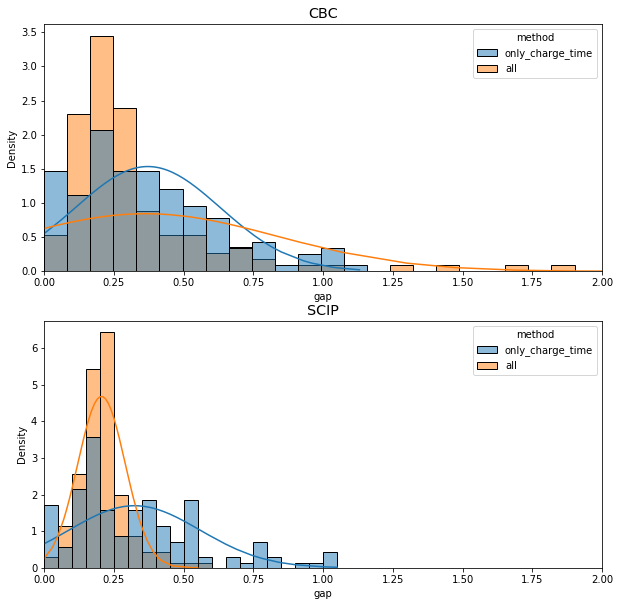

In [409]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
for idx1, solver in enumerate(data.solver.unique()):
    ax1 = axs[idx1]
    ax1.set_title(solver, fontsize="x-large")
    ax1.set_xlim(0,2)
    sn.histplot(data=data[data.solver==solver], x='gap', 
                hue='method',stat="density", common_norm=False, ax=ax1)
    for method in data.method.unique():
        x = data[(data.solver==solver) & (data.method==method)]["gap"].values
        x.sort()
        ax1.plot(x, norm.pdf(x, loc=x.mean(), scale=x.std()))       
print("Fig. 4")

Figure 4 above shows the density histograms of the gap for both solvers and using both optimization methods. As can be seen with the "all" method the distribution of gap values for CBC is broad, there are several values with gaps above 1. This is not the case for SCIP where the distribution is sharper and peaks below 0.25. Regarding the "only charge time" method, the distribution is similar in both solvers, however, it is a bit better for SCIP.

Let us perform again t-Test to estimated if the difference in mean gap values for the "only charge method" is significant when using a different solver:

In [403]:
cbc_only_charge = data[(data.solver=='CBC') & (data.method=='only_charge_time')]['gap'].values
scip_only_charge = data[(data.solver=='SCIP') & (data.method=='only_charge_time')]['gap'].values

ttest_res = ttest_paired_results(cbc_only_charge, scip_only_charge)
print("Table 3: ")
ttest_res

Table 3: 


t-Test Paired
T           3.239
p           0.001
df        139.000
r           0.265

Table 3 above shows the results of the t-Test for paired dependent samples of the gap means. After judging the result of the t-Test it is observed that the use of SCIP has a statistically significant influence on the mean gap value (T = 3.239, p < .005, n = 140) of the resulting routes. The effect is middle-weak with an r coefficient of 0.265.

It is worth mention that the version of SCIP that we have used during this experiment, the use of multithreading was not possible, only with a proper license it would be able to compile the solver with the multithreading feature. This is the reason why the average wall time of the calculated routes is larger than that of CBC (see table 1). If multithreading would have been available, the wall time would be considerable shorter, and also it would be possible to get even better gap values since the use of multithredings would allow a check more nodes during the bound and cut process.

We can then conclude that the use of other solvers might potentially enhance the quality of the calculated routes. Other commercial solvers like Gurubi or CPLEX are proven to be much faster than open source ones (see https://www.gurobi.com/pdfs/benchmarks.pdf). 

To finalize, we have summarize all relevant statistics from the performed experiment in table 4 below. 

In [407]:
desc_stats = pd.DataFrame()
for solver in data.solver.unique():
    for method in data.method.unique():
        stats = data[(data.solver==solver) & (data.method==method)][cols].describe().T
        index =[np.array([solver for item in stats.index]), 
                np.array([method for item in stats.index]),
               stats.index]
        index = pd.MultiIndex.from_arrays(index, names=['Solver', "method", "Parameter"])
        stats = stats.set_index(index)
        desc_stats = pd.concat([desc_stats, stats])
print("Table 4: Statistics Summary")
desc_stats.round(2)

Table 4: Statistics Summary


count      mean       std     min  \
Solver method           Parameter                                             
CBC    only_charge_time gap               140.0      0.37      0.26    0.00   
                        wall time         140.0   5273.23   2538.84  786.00   
                        norm_charge_time  140.0      0.30      0.08    0.09   
                        norm_tot_time     140.0      0.86      0.10    0.65   
       all              gap               137.0      0.36      0.47    0.00   
                        wall time         137.0   5024.90   3530.05  569.00   
                        norm_charge_time  137.0      0.33      0.08    0.09   
                        norm_tot_time     137.0      0.89      0.11    0.69   
SCIP   only_charge_time gap               140.0      0.32      0.24    0.00   
                        wall time         140.0  19698.61  12618.24  382.00   
                        norm_charge_time  140.0      0.29      0.08    0.08   
                        norm_tot_time     140.0      0.85      0.10    0.65   
       all              gap               140.0      0.21      0.09    0.00   
                        wall time         140.0  15115.32  12974.25  317.00   
                        norm_charge_time  140.0      0.33      0.07    0.12   
                        norm_tot_time     140.0      0.89      0.10    0.65   

                                              25%       50%       75%  \
Solver method           Parameter                                       
CBC    only_charge_time gap                  0.21      0.33      0.52   
                        wall time         3406.75   6020.50   6647.50   
                        norm_charge_time     0.24      0.29      0.37   
                        norm_tot_time        0.79      0.87      0.95   
       all              gap                  0.18      0.24      0.38   
                        wall time         1805.00   3605.00   8026.00   
                        norm_charge_time     0.28      0.34      0.40   
                        norm_tot_time        0.81      0.90      0.96   
SCIP   only_charge_time gap                  0.16      0.26      0.44   
                        wall time         5297.00  30062.00  30104.25   
                        norm_charge_time     0.24      0.28      0.36   
                        norm_tot_time        0.79      0.87      0.95   
       all              gap                  0.17      0.20      0.23   
                        wall time         2119.25  12097.00  30088.25   
                        norm_charge_time     0.28      0.33      0.39   
                        norm_tot_time        0.81      0.89      0.96   

                                               max  
Solver method           Parameter                   
CBC    only_charge_time gap                   1.13  
                        wall time         18178.00  
                        norm_charge_time      0.44  
                        norm_tot_time         0.99  
       all              gap                   4.38  
                        wall time         13275.00  
                        norm_charge_time      0.60  
                        norm_tot_time         1.53  
SCIP   only_charge_time gap                   1.05  
                        wall time         30345.00  
                        norm_charge_time      0.43  
                        norm_tot_time         0.99  
       all              gap                   0.55  
                        wall time         30291.00  
                        norm_charge_time      0.57  
                        norm_tot_time         1.29

## Summary

In this report we have study the effect of optimizing only the charge time vs. optimizing both drive and charge time on the resulting overall route times and their quality. We have found that optimizing only the charge time minimizes the overall route time by almost 10%, although the calculation time is slightly increased.

By optimizing only the charge time we get in average a normalized route time of 0.86 min/km, for which the 30% corresponds to charging time, in contrast to the 0.89 min/km and 33% when optimizing both drive and charge times simultaneously. This is a decrease of total route time of about 6% in average.

We have also compared the resulting routes calculated with another solver. These results show that there is a potential increase of the calculation performance which will mean a reduce in calculation time and an enhancement of the route quality by reducing the gap values.

In [237]:
# function to plot and compare hostograms of given attribute
def solver_method_hist(col, x_lim=False, cond=False):
    for solver in data.solver.unique():
        plt.figure(figsize=(7,5))
        plt.title(solver)
        if x_lim:
            plt.xlim(x_lim)
        sn.histplot(data=data[data.solver==solver], x=col, 
                    hue='method',stat="density", common_norm=False)
        for method in data.method.unique():
            x = data[(data.solver==solver) & (data.method==method)][col].values
            x.sort()
            plt.plot(x, norm.pdf(x, loc=x.mean(), scale=x.std()))